<h1>4. Machine Learning Model </h1>

In [107]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
import gc
import warnings
import os
pd.set_option('display.max_columns', 200)

<h2> 4.1 Reading data from file and storing to variable </h2>

In [2]:
#loaing Data
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

#Features for prediction(Indipendent variable)
features = [c for c in train_df.columns if c not in ['ID_code', 'target']] 
target = train_df['target']  #Labels

<h2> 4.2 Feature Extraction using response coading for train data</h2>

In [3]:
#Responce coding 
def t_encoding(tr,va,by):
    """Given two data frame (train and test) and feature (column name) ,the responce code fot that feature is calculated from\
    train dataframe and map it to test dataframe"""
    #what is responce coding?
    #for given X how many number of times Y occured /total number of times X occured 
    #ie y=1 intersection of X/ total number of times X occured 
    
    
    #calculating responce code
    df = tr.groupby(by).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(by)
    

    df['r'] = df['sum_y'] / df['count_y']  
    df.drop(['sum_y','count_y'],axis=1,inplace=True)
    
    #return mapped value 
    return va.merge(df,on=by,how='left')['r'].values

In [4]:
var_cols = features

#calling responce code function with each feature value and appending the return value to test dataset
for col in tqdm(var_cols):
    te_r = t_encoding(train_df,test_df,col) 
    test_df.loc[:,col+'_r'] = te_r
test_df.to_csv("test_df_after_responce_coding.csv",index=False)

<h2> 4.3 Feature Extraction using response coading for test data</h2>

In [6]:
#https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/88950
#spliting train data using StratifiedKFold and getting responce code for train data
folds = StratifiedKFold(n_splits=8, shuffle=False, random_state=99999)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    
    tr = train_df.loc[trn_idx,var_cols+['target']]
    va = train_df.loc[val_idx,var_cols+['target']]

    for col in tqdm(var_cols):
        encoded = t_encoding(tr,va,col)
        train_df.loc[val_idx,col+'_r'] = encoded
        
features = [col for col in train_df.columns if ('var' in col)]

train_df = train_df[features].reset_index(drop=True)
print('data prepared: {}'.format(train_df.shape))
train_df.to_csv("train_df_after_responce_coding.csv",index=False)

Fold 0



Fold 1



Fold 2



Fold 3



Fold 4



Fold 5



Fold 6



Fold 7



data prepared: (200000, 400)


<h2> 5. LightGBM optimization</h2>

In [49]:
#saving all feature name to a variable as list
predictors = train_df.columns.values.tolist()

In [50]:
#StratifiedKFold with 2 fold .using for optimization
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train_df, target))[0]

<h2> 5.1 Setting paramaters to optimize </h2>

In [51]:
#https://www.kaggle.com/fayzur/lgb-bayesian-parameters-finding-rank-average
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    max_bin,
    learning_rate,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    max_bin = int(max_bin)

    
    param = {
        'num_leaves': num_leaves,
        'max_bin': max_bin,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': 1,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,}
    
    # converting train data to lightgbm.basic.Dataset so that it can load faster
    xg_train = lgb.Dataset(train_df.iloc[bayesian_tr_index][predictors].values,
                           label=target.iloc[bayesian_tr_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    # converting validation data to lightgbm.basic.Dataset so that it can load faster
    xg_valid = lgb.Dataset(train_df.iloc[bayesian_val_index][predictors].values,
                           label=target.iloc[bayesian_val_index].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   
    num_round = 5000 #iteration to happen
    #training lgb for getting paramaters
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(train_df.iloc[bayesian_val_index][predictors].values, num_iteration=clf.best_iteration)   
    
    #AUC is used metric we are trying to increase
    score = metrics.roc_auc_score(target.iloc[bayesian_val_index].values, predictions)
    
    return score

<h2> 5.2 Setting Range values for each paramaters to optimize</h2>

In [52]:
# Bounded region of parameter space,values between this range is sent to paramater for optimization
bounds_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),
    'max_bin':(30,60),
    'learning_rate': (0.01, 0.3),
    'lambda_l1': (0, 3.0), 
    'lambda_l2': (0, 3.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

<h2> 5.3 Passing the boundry values to the model</h2>

In [53]:
#put all of Bounded parameter in BayesianOptimization object
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

#print the paramaters we set for optimization
print(LGB_BO.space.keys)

init_points = 10 #How many steps of random exploration you want to perform
n_iter = 8 # How many steps of bayesian optimization you want to perform

['lambda_l1', 'lambda_l2', 'learning_rate', 'max_bin', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'num_leaves']


In [54]:
print('-' * 130)
#this is where the optimization starts. .maximize function starts the optimization process
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_depth | min_da... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.882837
Early stopping, best iteration is:
[211]	valid_0's auc: 0.883642
|  1        |  0.8836   |  2.333    |  0.7126   |  0.249    |  58.97    |  14.67    |  11.8     |  0.609    |  16.63    |
Training until validation scores don't improve for 50 rounds
[250]	valid_0's auc: 0.804866
[500]	valid_0's auc: 0.840284
[750]	valid_0's auc: 0.858368
[1000]	valid_0's auc: 0.86895
[1250]	valid_0's auc: 0.875757
[1500]	valid_0's auc: 0.880979
[1750]	valid_0's auc: 0.884571
[2000]	valid_0's auc: 0.887243
[2250]	valid_0's auc: 0.889364
[2500]	vali

In [57]:
#display all Iterations auc score with the paramates which with which the auc is achived
for i, res in enumerate(LGB_BO.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.8836415176379367, 'params': {'lambda_l1': 2.3331072317214607, 'lambda_l2': 0.7126236601047369, 'learning_rate': 0.24904077447179687, 'max_bin': 58.97247594128999, 'max_depth': 14.67121336685872, 'min_data_in_leaf': 11.801738711259683, 'min_gain_to_split': 0.6090424627612779, 'num_leaves': 16.6328977190727}}
Iteration 1: 
	{'target': 0.8971366338006215, 'params': {'lambda_l1': 1.9248400342772074, 'lambda_l2': 2.1660546885508416, 'learning_rate': 0.02016059198941682, 'max_bin': 38.95348412667538, 'max_depth': 3.702149902584897, 'min_data_in_leaf': 17.855914138807982, 'min_gain_to_split': 0.3728540278748075, 'num_leaves': 15.197719273671455}}
Iteration 2: 
	{'target': 0.8961888416556874, 'params': {'lambda_l1': 0.7688398479798904, 'lambda_l2': 1.0427436454574759, 'learning_rate': 0.01272970332348113, 'max_bin': 40.7500134811491, 'max_depth': 14.389130180138524, 'min_data_in_leaf': 8.268485136975334, 'min_gain_to_split': 0.3193913663803646, 'num_leaves': 18.7665

In [58]:
print("Max AUC we got",LGB_BO.max['target'])
print("Paramaters which gave maximum AUC",LGB_BO.max['params'])

Max AUC we got 0.8976465574933451
Paramaters which gave maximum AUC {'lambda_l1': 0.5506494771002205, 'lambda_l2': 0.07411055445001147, 'learning_rate': 0.04551151859925723, 'max_bin': 59.18568109802394, 'max_depth': 12.014120719205591, 'min_data_in_leaf': 5.081842174131943, 'min_gain_to_split': 0.004801800840957271, 'num_leaves': 5.082741376762955}


<h2> 6. Training the model with best Paramaters which gave best AUC</h2>

In [65]:
#Setting best paramaters
param={'max_bin' : int(np.round(LGB_BO.max['params']['max_bin'])),
        'lambda_l1': LGB_BO.max['params']['lambda_l1'], 
        'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
        'learning_rate': LGB_BO.max['params']['learning_rate'], 
        'max_depth': int(np.round(LGB_BO.max['params']['max_depth'])), 
        'min_data_in_leaf': int(np.round(LGB_BO.max['params']['min_data_in_leaf'])), 
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'], 
        'num_leaves': int(np.round(LGB_BO.max['params']['num_leaves'])),
        'verbosity': 1,
        'objective': 'binary',}

In [66]:
param

{'max_bin': 59,
 'lambda_l1': 0.5506494771002205,
 'lambda_l2': 0.07411055445001147,
 'learning_rate': 0.04551151859925723,
 'max_depth': 12,
 'min_data_in_leaf': 5,
 'min_gain_to_split': 0.004801800840957271,
 'num_leaves': 5,
 'verbosity': 1,
 'objective': 'binary'}

In [73]:
#training and predicting lgb model with best param which we got through bayes optimization
folds = StratifiedKFold(n_splits=7, shuffle=False, random_state=99999)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    
    #converting train data to lightgbm.basic.Dataset so that it can load faster
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][predictors], label=target.iloc[trn_idx])

    #converting validation data to lightgbm.basic.Dataset so that it can load faster
    val_data = lgb.Dataset(train_df.iloc[val_idx][predictors], label=target.iloc[val_idx])

    clf = lgb.train(param, trn_data, 12000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 2000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][predictors], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[predictors], num_iteration=clf.best_iteration) / folds.n_splits
    
    #save mode at each fold
    clf.save_model('models/clf_cv'+str(fold_+1)+'.txt')
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("responce_code_aai.csv", index=False)

Fold 0
Training until validation scores don't improve for 2000 rounds
[1000]	training's binary_logloss: 0.209661	valid_1's binary_logloss: 0.224071
[2000]	training's binary_logloss: 0.185979	valid_1's binary_logloss: 0.207036
[3000]	training's binary_logloss: 0.172892	valid_1's binary_logloss: 0.201881
[4000]	training's binary_logloss: 0.162347	valid_1's binary_logloss: 0.199375
[5000]	training's binary_logloss: 0.153076	valid_1's binary_logloss: 0.198101
[6000]	training's binary_logloss: 0.144735	valid_1's binary_logloss: 0.197245
[7000]	training's binary_logloss: 0.137051	valid_1's binary_logloss: 0.196823
[8000]	training's binary_logloss: 0.129933	valid_1's binary_logloss: 0.196687
[9000]	training's binary_logloss: 0.123294	valid_1's binary_logloss: 0.196646
[10000]	training's binary_logloss: 0.11709	valid_1's binary_logloss: 0.196929
Early stopping, best iteration is:
[8260]	training's binary_logloss: 0.128149	valid_1's binary_logloss: 0.196556
Fold 1
Training until validation scor

<h2> 7. Finding Threshold </h2>

In [96]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [95]:
from sklearn.metrics import roc_curve
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(target, oof)

the maximum value of tpr*(1-fpr) 0.6818016091088409 for threshold 0.095


Text(0.5, 1, 'Confusion matrix for Train data')

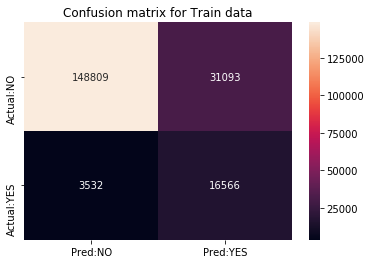

In [105]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt
heatmap(confusion_matrix(target, predict(oof, tr_thresholds1, train_fpr1, train_tpr1)),annot=True, fmt="d",xticklabels=["Pred:NO","Pred:YES"],yticklabels=["Actual:NO","Actual:YES"])
plt.title("Confusion matrix for Train data")

<h2> 8. Saving Response code to json for later use</h2>

In [112]:
#saving responce code to dict
responce_dic = {}
def t_encoding(tr,by):
   
    #calculating responce code
    df = tr.groupby(by).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(by)
    
    df['r'] = df['sum_y'] / df['count_y']
    mydict = dict(zip(df.iloc[:,0], df.r))
    responce_dic[by] = mydict
     
    return 

for i in features:
    te_r = t_encoding(train_df,i) 

In [113]:
#saving dict to json for later use
import json
#save dictionary
with open('responce_dic.json', 'w') as fp:
    json.dump(responce_dic, fp)
#load_dictionary 
with open('responce_dic.json', 'r') as fp:
    responce_dic = json.load(fp)